<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Гребневая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания, предоставляющая услуги такси, собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для этого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим и осмотрим данные

In [221]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
import pandas as pd

from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit


state = 42
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15,6)

In [222]:
pth1 = '/datasets/taxi.csv'
pth2 = '/Downloads/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [223]:
data.index.is_monotonic

True

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [225]:
data.isna().sum()

num_orders    0
dtype: int64

In [226]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [227]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


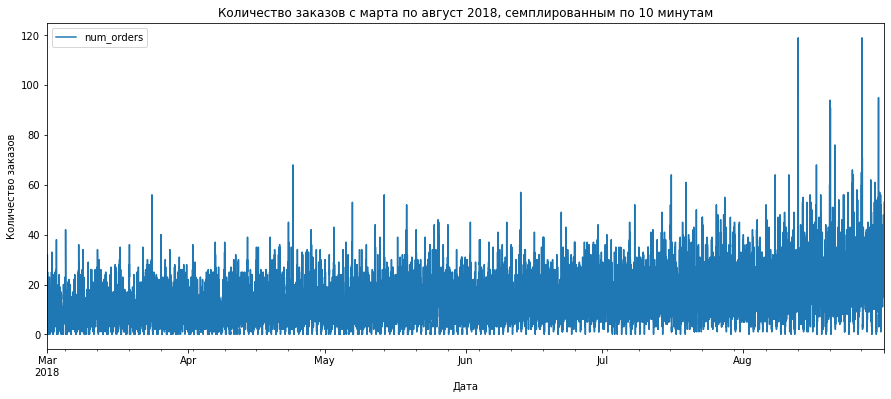

In [228]:
data.plot()
plt.title('Количество заказов с марта по август 2018, семплированным по 10 минутам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

In [229]:
data.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

In [230]:
data.index.month.unique()

Int64Index([3, 4, 5, 6, 7, 8], dtype='int64', name='datetime')

In [231]:
data.index.day.unique()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='datetime')

In [232]:
data.index.dayofweek.unique()

Int64Index([3, 4, 5, 6, 0, 1, 2], dtype='int64', name='datetime')

Выполним ресемплирование по часу.

In [233]:
data_h = data.resample('1H').sum()

In [234]:
data_h.shape

(4416, 1)

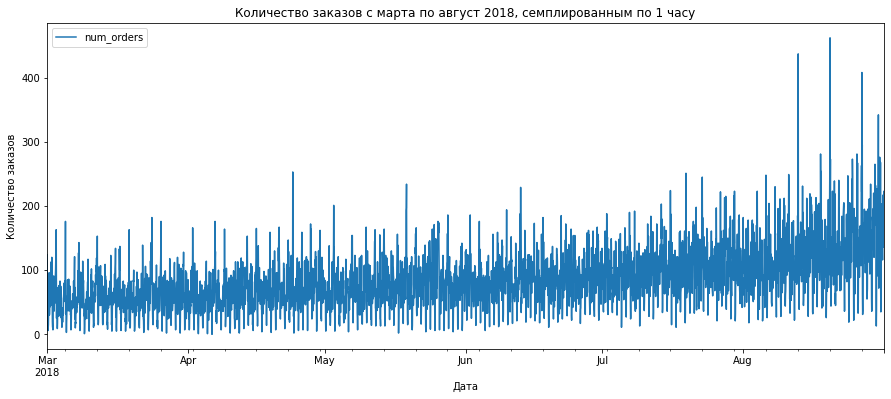

In [235]:
data_h.plot();
plt.title('Количество заказов с марта по август 2018, семплированным по 1 часу')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

## Анализ

1. Посмотрим стандартное отклонение ряда и скользящее среднее.
2. Разложим ряд на тренд, сезон, остатки. 
3. Проверим ряд на стационарность с помощью теста Dickey-Fuller
4. Построим ACF графики, сделать по ним выводы.
5. Проанализировать, какие признаки могут быть добавлены в датасет и обогатить ими данные.

In [236]:
data_h.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Посмотрим на скользящее среднее на примере одной недели.

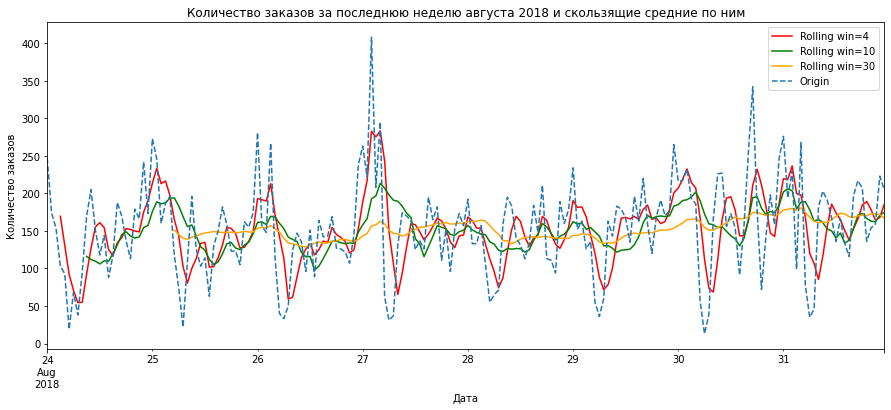

In [237]:
fig, ax = plt.subplots()

data_h['2018-08-24':'2018-08-31'].rolling(window=4).mean().plot(c='red', ax=ax)
data_h['2018-08-24':'2018-08-31'].rolling(window=10).mean().plot(c='green', ax=ax)
data_h['2018-08-24':'2018-08-31'].rolling(window=30).mean().plot(c='orange', ax=ax)
data_h['2018-08-24':'2018-08-31'].plot(label='Original', style='--', ax=ax)

plt.title('Количество заказов за последнюю неделю августа 2018 и скользящие средние по ним')
plt.xlabel('Дата')
plt.ylabel('Количество заказов') 

_ = ax.legend(['Rolling win=4','Rolling win=10', 'Rolling win=30', 'Origin']);

In [238]:
decomposed = seasonal_decompose(data_h)

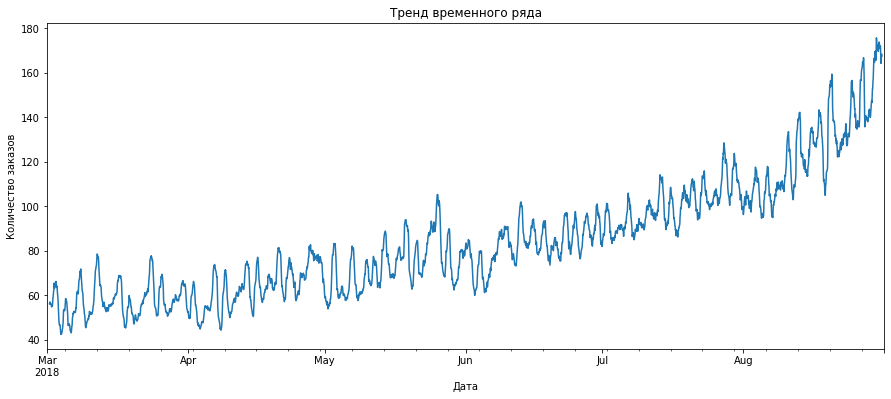

In [239]:
decomposed.trend.plot()
plt.title('Тренд временного ряда')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

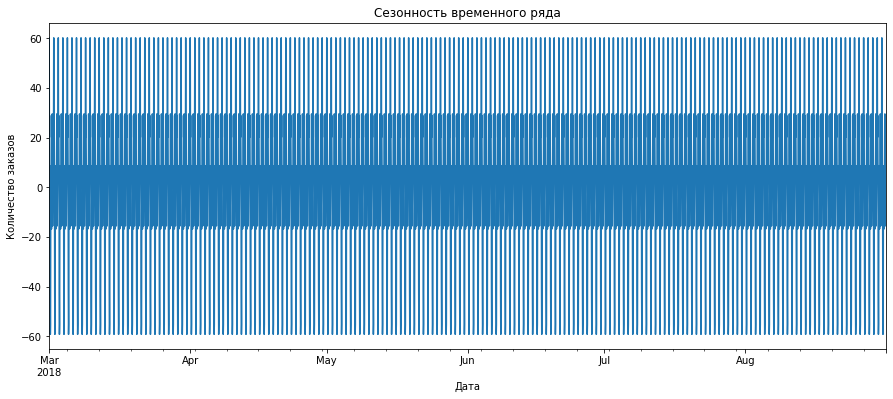

In [240]:
decomposed.seasonal.plot()
plt.title('Сезонность временного ряда')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

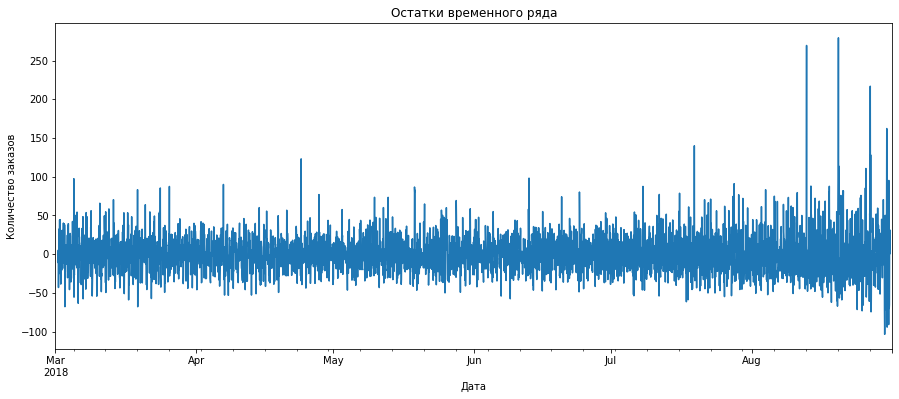

In [241]:
decomposed.resid.plot()
plt.title('Остатки временного ряда')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

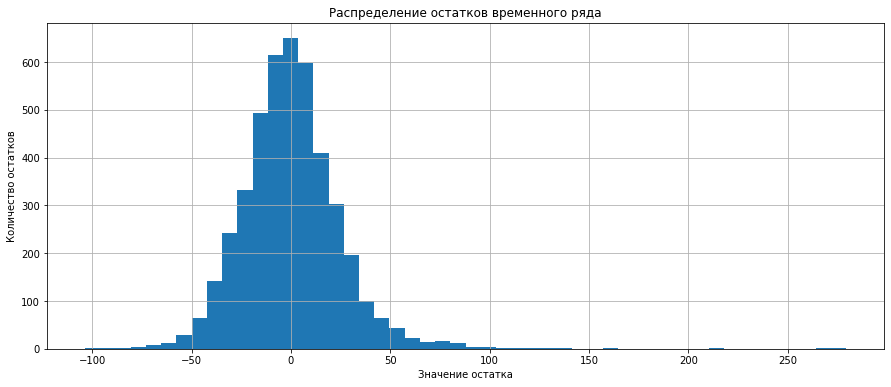

In [242]:
decomposed.resid.hist(bins=50)
plt.title('Распределение остатков временного ряда')
plt.xlabel('Значение остатка')
plt.ylabel('Количество остатков');

Распределение остатков похоже на распределение Пуассона.

Возьмем срез за 1 месяц, чтобы попробовать разглядеть более явную сезонность

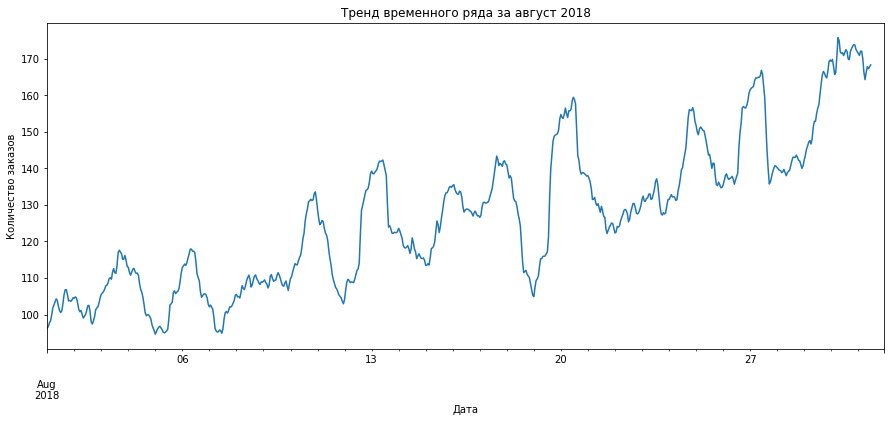

In [243]:
decomposed.trend['2018-08-01':'2018-08-31'].plot()
plt.title('Тренд временного ряда за август 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

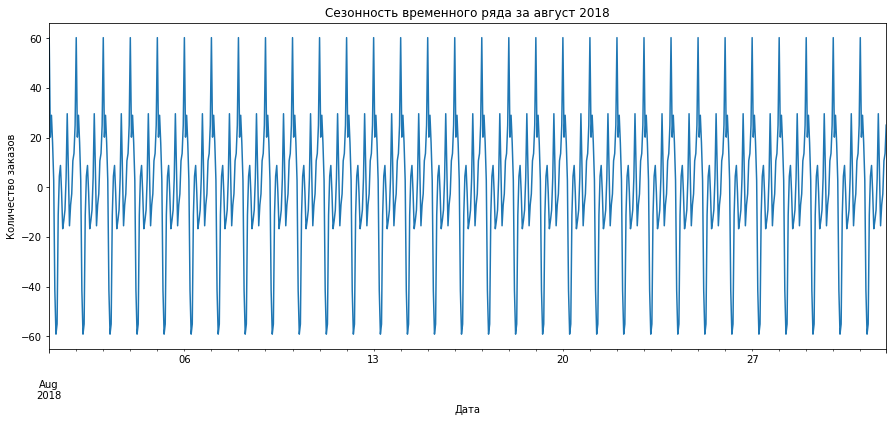

In [244]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot()
plt.title('Сезонность временного ряда за август 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

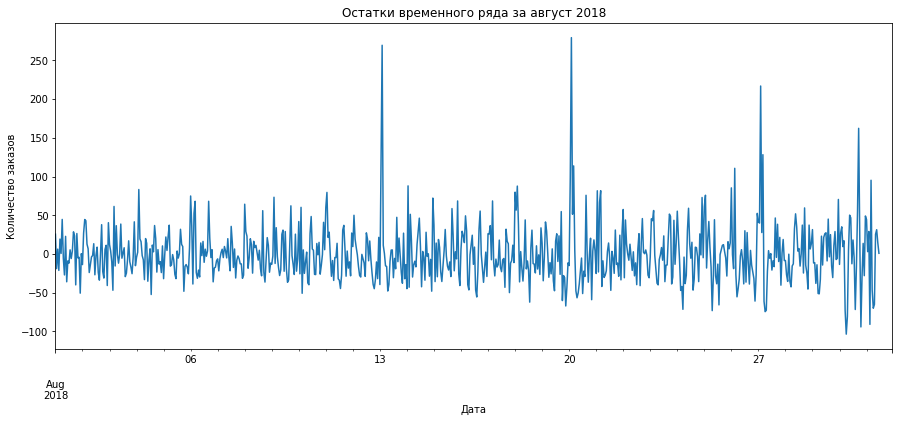

In [245]:
decomposed.resid['2018-08-01':'2018-08-31'].plot()
plt.title('Остатки временного ряда за август 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

Возьмем еще более мелкие срезы для сезонности

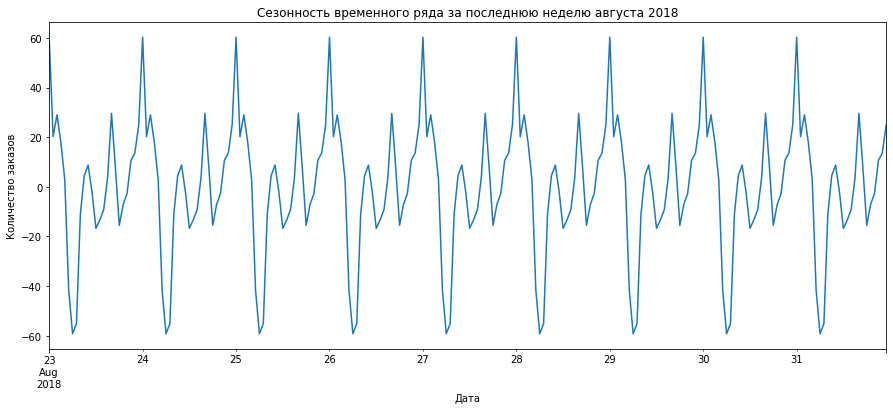

In [246]:
decomposed.seasonal['2018-08-23':'2018-08-31'].plot()
plt.title('Сезонность временного ряда за последнюю неделю августа 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

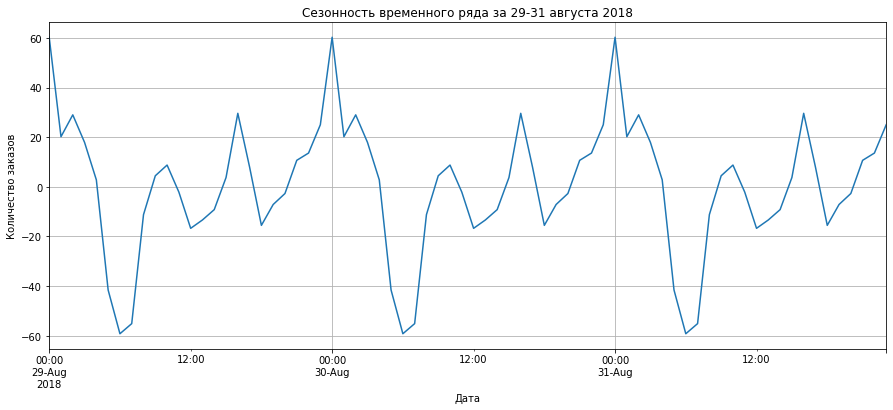

In [247]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot()
plt.title('Сезонность временного ряда за 29-31 августа 2018')
plt.grid(True)
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

На графиках очевидно, что в данных присутствует восходящий тренд и имеется сезонность - суточная. 

Ряд выглядит нестационарным - есть тренд и сезонность.

Пик в полночь объясняется прекращением движения общественного транспорта примерно в это время (закрывается метро, перестает ходить большая часть наземнного транспорта). Минимум, скорее всего, объясняется обратным - началом работы общественного транспорта. <br>
После минимума есть рост заказов с пиком в районе 10 утра - возможно, люди пытаются успеть на работу, в 12 обед - снова спад, затем рост и снова спад в районе 18 - возможно, не хотят стоять в пробках в час пик и выбирают метрополитен.


Для более точной оценки стационарности можно применить тест Дики-Фуллера. Нужно выполнить статистическую проверку гипотезы. В данном случае гипотезы звучат следующим образом.

* Нулевая гипотеза предполагает, что ряд нестационарный 
* Альтернативная гипотеза соответственно говорит, что ряд - стационарный 

Используем пороговое значение, равное 0.05 (5%).

In [248]:
adf_test = adfuller(data_h['num_orders'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402612906


Получается, что верна альтернативная гипотеза, хоть мы и наглядно видим суточную и недельную сезонность. Если использовать более строгое значение p-value в 0.01, верна будет нулевая гипотеза - ряд нестационарен, что больше соответствует тому, что мы видели на графиках.

Построим график антикорелляционной функции.

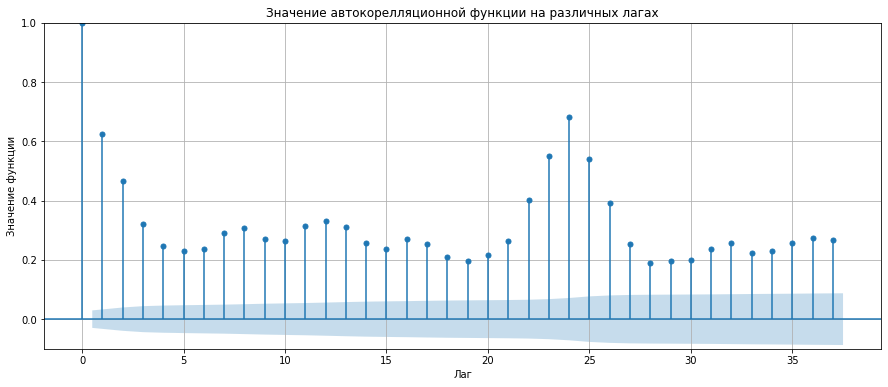

In [249]:
plot_acf(data_h)
plt.grid(True)
plt.ylim(-0.1, 1)
plt.title('Значение автокорелляционной функции на различных лагах')
plt.xlabel('Лаг')
plt.ylabel('Значение функции');

Сильнее всего корреляция заметна на лагах 1-3 и 22-26. При этом, все лаги на графике являются статистически значимыми.

Посмотрим также автокореляцию на семплированном по дню ряду

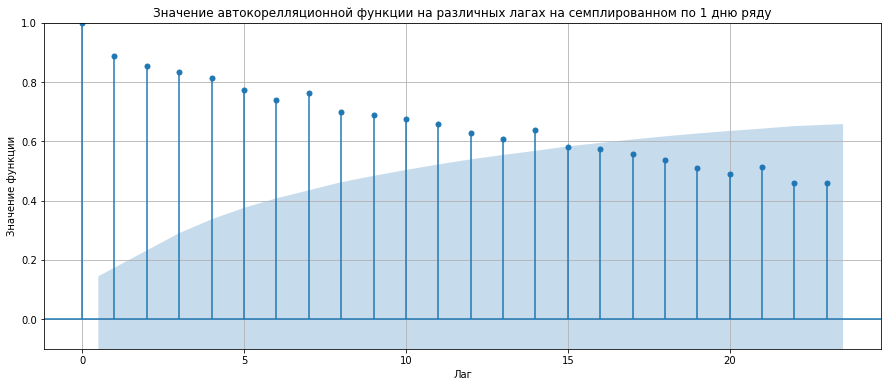

In [250]:
plot_acf(data.resample('1D').sum())
plt.grid(True)
plt.ylim(-0.1, 1)
plt.title('Значение автокорелляционной функции на различных лагах на семплированном по 1 дню ряду')
plt.xlabel('Лаг')
plt.ylabel('Значение функции');

У лага 7 значение автокорелляции выше, чем у лагов 6 и 8, а у лага 14 - чем у 13 и 15, что подвтерждает нашу теорию. Кроме того, ситуация аналогична и с лагом 21, но он уже не является статистически значимым.

*****
Что может использовать в качестве новых признаков?
* лаги целевой переменной
* экзогенные признаки - внешние признаки (год, день недели, праздники, акции и прочее)
* средние значения для кодирования признаков

Какие признаки могут быть полезны для модели? 
* Очевидно, что стоит добавить лаги 1-3, 22-26, а также 24 * 2, 24 * 3, 24 * 7 и 24 * 14. 
* Так как данные у нас за полгода, то и признак 'год', и признак 'месяц' не будут полезными - год у нас только один, а предсказания модели на данных по месяцам, отсутсвующим в датасете, может показать неожиданные результаты (ведь скорее всего, зимой люди пользуются такси не так же, как летом). 
* При этом, мы можем добавить столбец со средним значением целевой переменной по месяцу, чтобы сохранить некоторые данные от этого столбца.
* Так как у нас есть суточная сезонность, добавим столбцы 'час' и 'день недели'. 
* Скользящее среднее.


In [251]:
data_h['day'] = data_h.index.day
data_h['hour'] = data_h.index.hour
data_h['dayofweek'] = data_h.index.dayofweek
data_h['month'] = data_h.index.month

In [252]:
for lag in [1, 2, 3, 22, 23, 24, 25, 26, 24 * 2, 24 * 3, 24 * 7, 24 * 14]:
    data_h['lag_{}'.format(lag)] = data_h['num_orders'].shift(lag)

data_h['rolling_mean'] = data_h['num_orders'].shift().rolling(10).mean()

In [253]:
mean_month = dict(data_h.groupby('month')['num_orders'].mean())
data_h['mean_month'] = list(map(mean_month.get, data_h.month))

In [254]:
data_h['mean_month'].unique()

array([ 57.48387097,  63.80416667,  73.6827957 ,  83.20277778,
       100.00672043, 127.65188172])

In [255]:
data_h = data_h.drop('month', axis=1)

In [256]:
data_h.shape

(4416, 18)

In [257]:
data_h = data_h.dropna()

In [258]:
data_h.shape

(4080, 18)

In [259]:
1 - 4080 / 4416 

0.07608695652173914

Потеряно менее 10% данных

## Обучение

In [260]:
features = data_h.drop('num_orders', axis=1)
target = data_h['num_orders']

In [261]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False,
                                                                                  test_size=0.1, random_state=state)

In [262]:
features_train.shape

(3672, 17)

In [263]:
features_test.shape

(408, 17)

In [264]:
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [265]:
cv = TimeSeriesSplit(n_splits=3) # кросс-валидация для временных рядов

### Константная модель

Сравнивая модели с константной, сможем оценить их адекватность.

In [266]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(features_train, target_train)
dummy_pred = dummy_regr.predict(features_test)
mean_squared_error(target_test, dummy_pred, squared=False)

84.72372795064362

### Линейная регрессия

In [267]:
LR = LinearRegression()

In [268]:
l_scores = cross_val_score(LR, features_train, target_train, scoring='neg_root_mean_squared_error', cv=cv) 
linear_score = sum(l_scores) / len(l_scores) * -1
print('Средняя оценка качества модели:', linear_score)

Средняя оценка качества модели: 22.987448121220307


Feature 0: day , Score: 0.7466550053017934
Feature 1: hour , Score: -0.07315268212957954
Feature 2: dayofweek , Score: -0.164244581593138
Feature 3: lag_1 , Score: 3.02383889983865
Feature 4: lag_2 , Score: 1.9548041424914104
Feature 5: lag_3 , Score: -0.13352613309637337
Feature 6: lag_22 , Score: 0.22153004562825288
Feature 7: lag_23 , Score: 1.444844992963868
Feature 8: lag_24 , Score: 4.044401208805722
Feature 9: lag_25 , Score: -0.40959877924580607
Feature 10: lag_26 , Score: -1.8618711534719306
Feature 11: lag_48 , Score: 5.7907407501680535
Feature 12: lag_72 , Score: 4.035713060633723
Feature 13: lag_168 , Score: 11.47794484817792
Feature 14: lag_336 , Score: 8.723031226573749
Feature 15: rolling_mean , Score: 2.5708574451237443
Feature 16: mean_month , Score: -1.1287442650748638


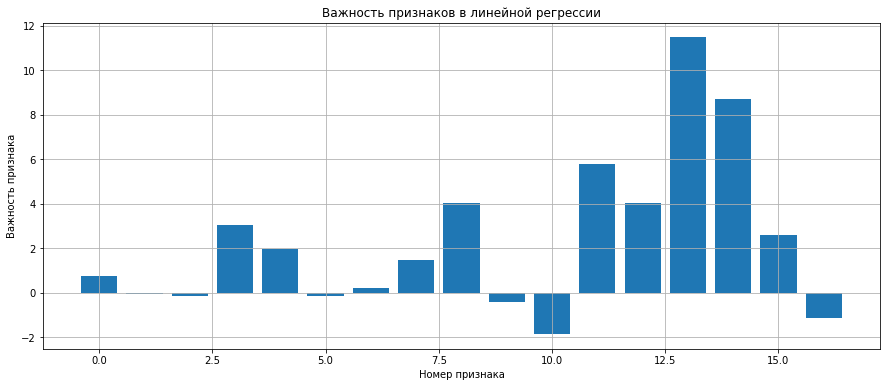

In [269]:
LR.fit(features_train, target_train)
importance = LR.coef_
for i,v in enumerate(importance):
    print(f'Feature {i}: {features.columns[i]} , Score: {v}')
plt.bar([x for x in range(len(importance))], importance)
plt.title('Важность признаков в линейной регрессии')
plt.xlabel('Номер признака')
plt.ylabel('Важность признака');
plt.grid(True)
plt.show()

Наименее полезный признак - час, а наиболее - недельный и двухнедельный лаг.

### Гребневая регрессия

In [270]:
ridge_reg = Ridge(random_state=state)

In [271]:
params = [{'alpha':[0.1, 0.5, 1, 10, 50, 75, 100, 250, 500],
          'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

ridge_cv = GridSearchCV(ridge_reg, params, scoring='neg_root_mean_squared_error', cv=cv)
ridge_cv.fit(features_train, target_train)
print('Лучшие параметры', ridge_cv.best_params_)
print('Лучшая RMSE', ridge_cv.best_score_ * -1)

Лучшие параметры {'alpha': 100, 'solver': 'auto'}
Лучшая RMSE 22.461811476723113


### Случайный лес

In [272]:
rf = RandomForestRegressor(random_state=state)
forest_params = {
    'max_depth': range(3, 12, 2),
    'n_estimators': (15, 50, 75, 100, 150) 
}

forest = GridSearchCV(rf, 
                      forest_params, 
                      cv=cv, 
                      verbose=2, 
                      scoring='neg_root_mean_squared_error')

forest.fit(features_train, target_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END .......................max_depth=3, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=15; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=3, n_estimators=75; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=75; total time=   0.3s
[CV] END .......................max_depth=3, n_estimators=75; total time=   0.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=3, n_es

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': range(3, 12, 2),
                         'n_estimators': (15, 50, 75, 100, 150)},
             scoring='neg_root_mean_squared_error', verbose=2)

In [273]:
forest.best_score_ * -1

23.310652048936507

In [274]:
forest.best_params_

{'max_depth': 7, 'n_estimators': 150}

### LightGBM

In [275]:
lgbm = lgb.LGBMRegressor(objective='regression', random_state=state)

lgb_params = {
      'learning_rate': [0.1, 0.01],
      'n_estimators': [50, 100, 150],
      'max_depth': [3, 5, 7, 9],
}

lgbmachine = GridSearchCV(estimator=lgbm, 
                     param_grid=lgb_params,
                     cv=cv,
                     verbose=2,
                     scoring='neg_root_mean_squared_error')

lgbmachine.fit(features_train, target_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  29.3s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   4.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  27.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=  54.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time= 1.4min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 1.0min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   7.8s
[CV] END ....learning_rate=0.1, max_depth=5, n_e

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [276]:
lgbmachine.best_score_ * -1

23.24268623481144

In [277]:
lgbmachine.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

### CatBoost

In [278]:
catboost = CatBoostRegressor(loss_function='RMSE', random_state=state, verbose=False)


cat_params = {
      'learning_rate': [0.1, 0.01],
      'depth': [5, 7, 9],
}

catboost_grid = catboost.grid_search(cat_params, 
                                     features_train, target_train,
                                     cv=cv,
                                     verbose=False,
                                     plot=True,
                                     shuffle=False,)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 28.63128644
bestIteration = 132


bestTest = 28.50218788
bestIteration = 937


bestTest = 28.76593578
bestIteration = 167


bestTest = 29.17094623
bestIteration = 997


bestTest = 30.75063909
bestIteration = 376


bestTest = 30.78160628
bestIteration = 999

Training on fold [0/3]

bestTest = 20.34538794
bestIteration = 947

Training on fold [1/3]

bestTest = 20.5190301
bestIteration = 400

Training on fold [2/3]

bestTest = 27.38144556
bestIteration = 983



In [279]:
catboost_grid['params']

{'depth': 5, 'learning_rate': 0.01}

In [280]:
model_cat = CatBoostRegressor(depth=5, 
                              learning_rate=0.01,
                              loss_function='RMSE',
                              random_state=state,
                              verbose=0)

cat_scores = cross_val_score(model_cat, features_train, target_train, scoring='neg_root_mean_squared_error', cv=cv) 
cat_score = sum(cat_scores) / len(cat_scores) * -1
print('Средняя оценка качества модели:', cat_score)

Средняя оценка качества модели: 22.901486216130383


In [281]:
df = pd.DataFrame([['LR', linear_score], 
                   ['Ridge', ridge_cv.best_score_ * -1], 
                   ['RF', forest.best_score_ * -1],
                   ['LightGBM', lgbmachine.best_score_ * -1],
                   ['CatBoost', cat_score]], 
                   columns=['Model', 'RMSE on CV'])

In [282]:
df.sort_values(by='RMSE on CV')

,Model,RMSE on CV
1,Ridge,22.461811
4,CatBoost,22.901486
0,LR,22.987448
3,LightGBM,23.242686
2,RF,23.310652


Лучший результат показала гребневая регрессия. Проверим ее на тестовой выборке.

## Тестирование

In [283]:
preds_test = ridge_cv.best_estimator_.predict(features_test)

In [284]:
mean_squared_error(target_test, preds_test, squared=False)

33.860705330872875

In [285]:
preds_test = pd.Series(preds_test, index=target_test.index)

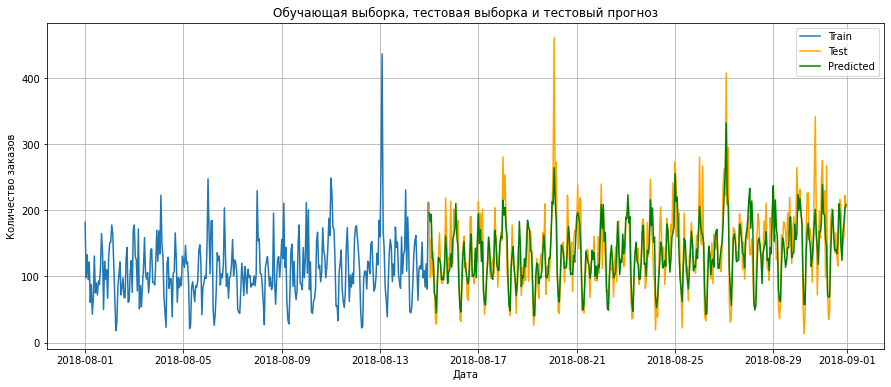

In [286]:
plt.plot(target_train['2018-08-01':'2018-08-31'], label='Train')
plt.plot(target_test, color = 'orange', label='Test')
plt.plot(preds_test, color = 'green', label='Predicted')

plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend()
plt.grid()
plt.show()

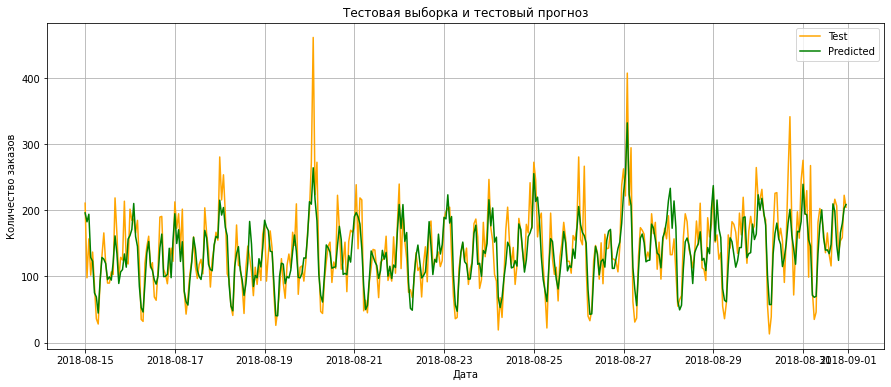

In [287]:
plt.plot(target_test, color = 'orange', label='Test')
plt.plot(preds_test, color = 'green', label='Predicted')

plt.title('Тестовая выборка и тестовый прогноз')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend()
plt.grid()
plt.show()

## Вывод 

Для анализа получены исторические данных о количестве заказов такси с шагом в 10 минут в промежутке март-август 2018 года, которые затем были ресемплированы по часу.

В ходе анализа был выявлен возрастающий тренд, а также присутствующая суточная сезонность с максимумом около полуночи и минимум около 6 утра.

При этом, статистический тест Дики-Фуллера показал, что ряд является стационарным.

После создания дополнительных признаков (на основе лагов, скользящего среднего, данных о дате и времени и среднем по месяцу) и масштабирования данных при помощи кросс-валидации были проверены следующие модели: линейная и гребневая регрессия, случайный лес, LightGBM и CatBoost. 

Лучший результат показала гребневая регрессия - RMSE = 22.46.

На тестовой выборке эта модель показала RMSE = 33.86, то есть в среднем ошибается на примерно 34 заказа такси в час. На графиках заметно, что модель значительно отстает в пиковых значениях.